# Домашняя работа №5

# Задание
Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). <br>
Опишите, какой результата вы получили? <br>
Что помогло вам улучшить ее точность?

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formats = ['svg']  # Для четких графиков

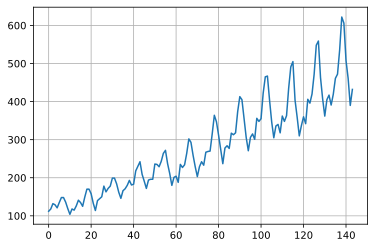

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


In [2]:
df = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(df), plt.grid(), plt.show()
df

#### Нормализуем

In [3]:
dataset = df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

#### Разделим

In [4]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return numpy.array(X), numpy.array(y)

In [5]:
numpy.random.seed(42)

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 4  # кол-во примеров
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [7]:
# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
X_train.shape, X_test.shape

((91, 4, 1), (43, 4, 1))

#### Модель

In [9]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [10]:
# Обучим
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=0, shuffle=False)

In [11]:
# Предскажем
train_predict = model.predict(X_train, batch_size=batch_size)
model.reset_states()
test_predict = model.predict(X_test, batch_size=batch_size)

43/43 [==============================] - 0s 693us/step


In [12]:
# Вернем размеры значений
train_predict_inversed = scaler.inverse_transform(train_predict)
y_train_inversed = scaler.inverse_transform([y_train])
test_predict_inversed = scaler.inverse_transform(test_predict)
y_test_inversed = scaler.inverse_transform([y_test])

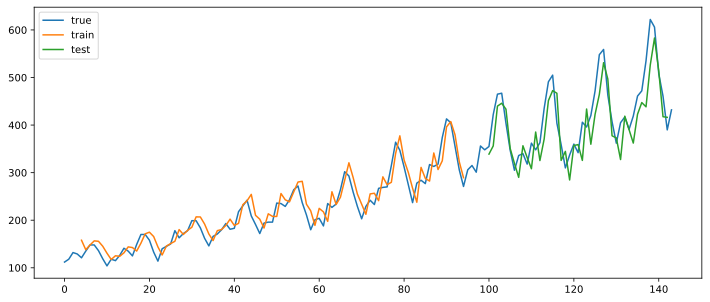

In [13]:
train_predict_plot = numpy.empty_like(dataset)
train_predict_plot[:, :] = numpy.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict_inversed

test_predict_plot = numpy.empty_like(dataset)
test_predict_plot[:, :] = numpy.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict_inversed

plt.figure(figsize=(12,5))
plt.plot(scaler.inverse_transform(dataset), label='true')
plt.plot(train_predict_plot, label='train')
plt.plot(test_predict_plot, label='test')
plt.legend()
plt.show()

In [14]:
# Посчитаем RMSE
train_score = math.sqrt(mean_squared_error(y_train_inversed[0], train_predict_inversed[:,0]))
print(f'Train score: {train_score:.2f} RMSE')
test_score = math.sqrt(mean_squared_error(y_test_inversed[0], test_predict_inversed[:,0]))
print(f'Test  score: {test_score:.2f} RMSE')

Train score: 21.93 RMSE
Test  score: 45.18 RMSE


In [15]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


#### Что получили:
- Модель со среднеквадратичной ошибкой в 45 пассажиров на тесте
- Визуально похожий график по предсказаниям

#### Что помогло увеличить точность:
- Нахождение оптимального кол-ва примеров, получилось 4 
- Увеличение кол-ва эпох